# A/B Test for MuscleHub
***

## Introduction

Like most businesses, Janet keeps her data in a SQL database. You have already downloaded the data from her database to a csv file, and will load it into a Jupyter Notebook using pandas to conduct A/B testing for the MuscleHub Gym.

## Import the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [191]:
applications = pd.read_csv("applications.csv")
applications.head()

,first_name,last_name,email,gender,application_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [192]:
tests = pd.read_csv("fitness_tests.csv")
tests.head()

,first_name,last_name,email,gender,fitness_test_date
0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [193]:
purchases = pd.read_csv("purchases.csv")
purchases.head()

,first_name,last_name,email,gender,purchase_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


In [194]:
visits = pd.read_csv("visits.csv")
visits.head()

,first_name,last_name,email,gender,visit_date
0,Karen,Manning,Karen.Manning@gmail.com,female,5-1-17
1,Annette,Boone,AB9982@gmail.com,female,5-1-17
2,Salvador,Merritt,SalvadorMerritt12@outlook.com,male,5-1-17
3,Martha,Maxwell,Martha.Maxwell@gmail.com,female,5-1-17
4,Andre,Mayer,AndreMayer90@gmail.com,male,5-1-17


## Join all of your data

It would be helpful to have a single DataFrame with all of this data. 

Create a DataFrame containing all of this data. We only want to pull data where `visit_date` is on or after 7-1-17.

In [195]:
visits = visits[visits['visit_date'] >= '7-1-17']
visits.shape

(5000, 5)

In [196]:
df = visits.merge(tests,on=['first_name', 'last_name', 'email', 'gender'], how='left').merge(
    applications,on=['first_name', 'last_name', 'email', 'gender'], how='left').merge(
    purchases,on=['first_name', 'last_name', 'email', 'gender'], how='left')
    
df.head()

,first_name,last_name,email,gender,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,KimWalter58@gmail.com,female,7-1-17,2017-07-03,NaN,NaN
1,Tom,Webster,TW3857@gmail.com,male,7-1-17,2017-07-02,NaN,NaN
2,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17,NaN,2017-07-04,2017-07-04
3,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,RB6305@hotmail.com,female,7-1-17,2017-07-02,NaN,NaN


In [197]:
df.shape

(5004, 8)

## Visualize the Groups

Having compiled the DataFrame we can use to begin our project.

Visualization that depicts the distribution of potential customers that were given a fitness test and those that were not

In [198]:
df["test_given"] = df["fitness_test_date"].apply(lambda x : "Group A" if pd.notna(x) else "Group B")
df["has_applied"] = df["application_date"].apply(lambda x : "applied" if pd.notna(x) else "not applied")
df["is_member"] = df["purchase_date"].apply(lambda x : "member" if pd.notna(x) else "not member")
df.head()

,first_name,last_name,email,gender,visit_date,fitness_test_date,application_date,purchase_date,test_given,has_applied,is_member
0,Kim,Walter,KimWalter58@gmail.com,female,7-1-17,2017-07-03,NaN,NaN,Group A,not applied,not member
1,Tom,Webster,TW3857@gmail.com,male,7-1-17,2017-07-02,NaN,NaN,Group A,not applied,not member
2,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17,NaN,2017-07-04,2017-07-04,Group B,applied,member
3,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17,2017-07-01,2017-07-03,2017-07-05,Group A,applied,member
4,Roberta,Best,RB6305@hotmail.com,female,7-1-17,2017-07-02,NaN,NaN,Group A,not applied,not member


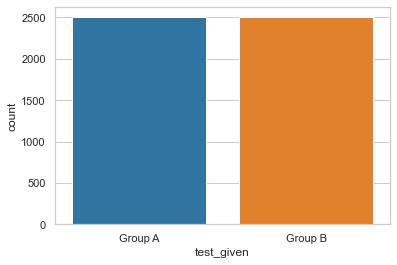

In [199]:
sns.set_context("notebook")
sns.set_style("whitegrid")
sns.countplot(x="test_given", data=df)
plt.show()
plt.close()


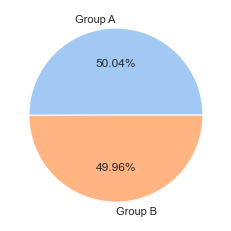

In [200]:
data = df.test_given.value_counts()
labels = data.index.values.tolist() 
colors = sns.color_palette('pastel')[0:2]
plt.pie(data, labels = labels, colors = colors, autopct='%0.2f%%')
plt.show()
plt.close()

## Determine the count of applications

Recall that the sign-up process for MuscleHub has several steps:

1. Take a fitness test with a personal trainer (only Group A).
2. Fill out an application for the gym.
3. Send in their payment for their first month's membership.

Determine the percentage of people in each group who complete Step 2, filling out an application.

In [201]:
group_a = df[df.test_given == "Group A"]
app_a = group_a.dropna(subset=["application_date"])
app_a_count = len(app_a)
no_app_a_count = len(group_a) - app_a_count
app_perc_a = (app_a_count / group_a.first_name.count() * 100).round(2)
print(f"{app_perc_a}% of people in group A filled out an application")


9.98% of people in group A filled out an application


In [202]:
group_b = df[df.test_given == "Group B"]
app_b = group_b.dropna(subset=["application_date"])
app_b_count = len(app_b)
no_app_b_count = len(group_b) - app_b_count
app_perc_b = (app_b_count / group_a.first_name.count() * 100).round(2)
print(f"{app_perc_b}% of people in group B filled out an application")

12.98% of people in group B filled out an application


In [203]:
grouped_app = df.groupby(["test_given", "has_applied"]).first_name.count().reset_index()
grouped_app = grouped_app.pivot(index="test_given", columns="has_applied", values="first_name").reset_index()
grouped_app["Total"] = grouped_app["applied"] + grouped_app["not applied"]
grouped_app["Application percent"] = grouped_app["applied"] / grouped_app["Total"]
grouped_app

has_applied,test_given,applied,not applied,Total,Application percent
0,Group A,250,2254,2504,0.09984
1,Group B,325,2175,2500,0.13000


It looks like more people from Group B turned in an application.  Why might that be?

We need to know if this difference is statistically significant.

## Calculate the statistical significance of applications

Having calculated the difference in who turned in an application between groups, determine if this difference is statistically significant.

In [204]:
contingency = [[app_a_count, no_app_a_count], [app_b_count, no_app_b_count]]
chi2, pval, dof, expected = chi2_contingency(contingency)
pval

0.0009647827600722304

A p-value of 0.00096 is less than a significance threshold of 0.05 which indicate a strong statistically significant difference between the two groups

## Detemine the count of memberships from applications

Of those who picked up an application, how many purchased a membership?

Determine how many potential customers purchased a membership out of those that picked up an application.

In [205]:
# Percentage of customers who picked an application and purchase a membership in group A
app_purchase_a = app_a.dropna(subset=["purchase_date"])
len(app_purchase_a) / len(app_a) * 100

80.0

In [206]:
# Percentage of customers who picked an application and purchase a membership in group B
app_purchase_b = app_b.dropna(subset=["purchase_date"])
len(app_purchase_b) / len(app_b) * 100

76.92307692307693

In [207]:
apps = df.dropna(subset=["application_date"])
grouped = apps.groupby(["test_given", "is_member"]).first_name.count().reset_index()
grouped = grouped.pivot(index="test_given", columns="is_member", values="first_name").reset_index()
grouped["Total"] = grouped["member"] + grouped["not member"]
grouped["Member percent"] = grouped["member"] / grouped["Total"]
grouped

is_member,test_given,member,not member,Total,Member percent
0,Group A,200,50,250,0.800000
1,Group B,250,75,325,0.769231


It looks like people who took the fitness test were more likely to purchase a membership if they picked up an application. Why might that be?

## Calculate the statistical significance of memberships

Calculate if the difference between the following groups is statistically significant: 
- The customers that picked up an application and took a fitness test.
- The customers that did not take a fitness test and picked up an application.

In [208]:
# Customers who picked up an application and took a fitness test
members = df[df["is_member"] == "member"]
not_members= df[df["is_member"] == "not member"]
app_fit = members.dropna(subset=["application_date", "fitness_test_date"])
app_fit

,first_name,last_name,email,gender,visit_date,fitness_test_date,application_date,purchase_date,test_given,has_applied,is_member
3,Marcus,Bauer,Marcus.Bauer@gmail.com,male,7-1-17,2017-07-01,2017-07-03,2017-07-05,Group A,applied,member
11,Valerie,Munoz,VMunoz1998@gmail.com,female,7-1-17,2017-07-03,2017-07-05,2017-07-06,Group A,applied,member
131,Nora,Collier,NoraCollier26@gmail.com,female,7-11-17,2017-07-11,2017-07-15,2017-07-20,Group A,applied,member
149,Lonnie,Brennan,Lonnie.Brennan@gmail.com,male,7-11-17,2017-07-12,2017-07-17,2017-07-17,Group A,applied,member
154,Agnes,Raymond,AR4756@aol.com,female,7-11-17,2017-07-13,2017-07-17,2017-07-18,Group A,applied,member
...,...,...,...,...,...,...,...,...,...,...,...
4893,Anna,Aguilar,AA9306@gmail.com,female,9-8-17,2017-09-09,2017-09-10,2017-09-16,Group A,applied,member
4918,Erika,Guthrie,ErikaGuthrie24@gmail.com,female,9-8-17,2017-09-13,2017-09-11,2017-09-13,Group A,applied,member
4934,Steve,Middleton,SM5586@gmail.com,male,9-8-17,2017-09-08,2017-09-11,2017-09-17,Group A,applied,member
4944,Frances,Kerr,FK7982@gmail.com,female,9-8-17,2017-09-12,2017-09-10,2017-09-15,Group A,applied,member


In [209]:
# Customers who didn't take a fitness test and picked up an application
app_nofit = members[pd.isna(df["fitness_test_date"])]
app_nofit = app_nofit.dropna(subset=["application_date"])
app_nofit

C:\Users\karim\AppData\Local\Temp/ipykernel_9916/3130790301.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app_nofit = members[pd.isna(df["fitness_test_date"])]


,first_name,last_name,email,gender,visit_date,fitness_test_date,application_date,purchase_date,test_given,has_applied,is_member
2,Edward,Bowen,Edward.Bowen@gmail.com,male,7-1-17,NaN,2017-07-04,2017-07-04,Group B,applied,member
35,Michael,Burks,MB9820@gmail.com,male,7-1-17,NaN,2017-07-07,2017-07-13,Group B,applied,member
69,Sonia,Harrell,SoniaHarrell53@gmail.com,female,7-10-17,NaN,2017-07-12,2017-07-14,Group B,applied,member
95,Marlene,Barron,MBarron1979@yahoo.com,female,7-10-17,NaN,2017-07-11,2017-07-15,Group B,applied,member
122,Lisa,Kramer,Lisa.Kramer@gmail.com,female,7-10-17,NaN,2017-07-14,2017-07-18,Group B,applied,member
...,...,...,...,...,...,...,...,...,...,...,...
4864,Terrence,Sandoval,TS7554@gmail.com,male,9-7-17,NaN,2017-09-07,2017-09-10,Group B,applied,member
4868,Rosa,Woodard,RosaWoodard27@outlook.com,female,9-7-17,NaN,2017-09-08,2017-09-14,Group B,applied,member
4905,Miriam,Phelps,MiriamPhelps13@gmail.com,female,9-8-17,NaN,2017-09-13,2017-09-15,Group B,applied,member
4964,Raymond,Cantrell,Raymond.Cantrell@gmail.com,male,9-9-17,NaN,2017-09-13,2017-09-18,Group B,applied,member


In [210]:
# p-value
contingency = [[200, 50], [250, 75]]
chi2, pval, dof, expected = chi2_contingency(contingency)
pval

0.43258646051083327

## Detemine the count of all memberships

Previously, you looked at what percentage of people who picked up applications purchased memberships. 

Now, determine what percentage of ALL visitors purchased memberships. 

In [211]:
grouped_members = df.groupby(["test_given", "is_member"]).first_name.count().reset_index()
grouped_members = grouped_members.pivot(index="test_given", columns="is_member", values="first_name").reset_index()
grouped_members["Total"] = grouped_members["member"] + grouped_members["not member"]
grouped_members["Member percent"] = grouped_members["member"] / grouped_members["Total"]
grouped_members

is_member,test_given,member,not member,Total,Member percent
0,Group A,200,2304,2504,0.079872
1,Group B,250,2250,2500,0.100000


## Calculate the statistical significance between groups

Determine if there is a significant difference in memberships between Group A and Group B.

In [212]:
# p-value
contingency = [[200, 2304], [250, 2250]]
chi2, pval, dof, expected = chi2_contingency(contingency)
pval

0.014724114645783203

## Visualize the results

## Percent of visitors who apply


In [213]:
grouped_app

has_applied,test_given,applied,not applied,Total,Application percent
0,Group A,250,2254,2504,0.09984
1,Group B,325,2175,2500,0.13000


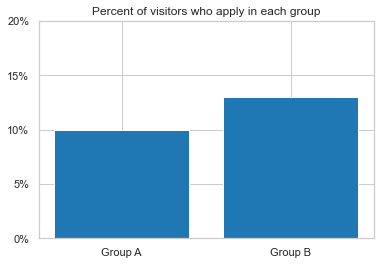

In [214]:
data = grouped_app["Application percent"].values
ax = plt.subplot()
plt.bar(range(len(data)), data)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(["Group A", "Group B"])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(["0%", "5%", "10%", "15%", "20%"])
plt.title("Percent of visitors who apply in each group")
plt.show()
plt.close()

## Percent of applicants who purchase a membership.


In [215]:
grouped

is_member,test_given,member,not member,Total,Member percent
0,Group A,200,50,250,0.800000
1,Group B,250,75,325,0.769231


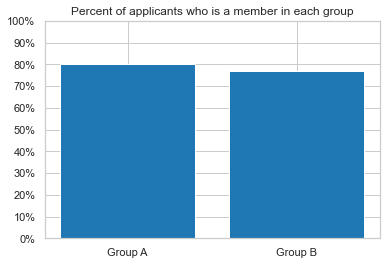

In [216]:
data = grouped["Member percent"].values
ax = plt.subplot()
plt.bar(range(len(data)), data)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(["Group A", "Group B"])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])
plt.title("Percent of applicants who is a member in each group")
plt.show()
plt.close()

## Percent of visitors who purchase a membership.

In [217]:
grouped_members

is_member,test_given,member,not member,Total,Member percent
0,Group A,200,2304,2504,0.079872
1,Group B,250,2250,2500,0.100000


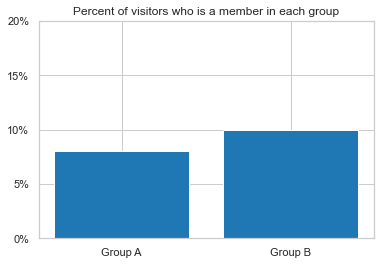

In [218]:
data = grouped_members["Member percent"].values
ax = plt.subplot()
plt.bar(range(len(data)), data)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(["Group A", "Group B"])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(["0%", "5%", "10%", "15%", "20%"])
plt.title("Percent of visitors who is a member in each group")
plt.show()
plt.close()

# Conclusion